## Imports

In [1]:
import pandas as pd
import numpy as np

from time import perf_counter

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from scipy.linalg import svd

from scipy.linalg import lu_factor, lu_solve
from scipy.linalg import cho_factor, cho_solve
from scipy.linalg import qr, solve_triangular

import scipy.stats

from statsmodels.stats.stattools import durbin_watson

import matplotlib.pyplot as plt
import plotnine as p9
import seaborn as sns

In [2]:
np.set_printoptions(suppress=True)

## Load in data

In [3]:
df = pd.read_csv('./Concrete_Data.csv')
col_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'age', 'strength']
df.columns = col_names
df

,c1,c2,c3,c4,c5,c6,c7,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


## Exploratory Data Analysis

In [4]:
df.describe()

,c1,c2,c3,c4,c5,c6,c7,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [5]:
df.isna().sum()

c1          0
c2          0
c3          0
c4          0
c5          0
c6          0
c7          0
age         0
strength    0
dtype: int64

In [14]:
# proportion of zeros
df[df==0].count().sum() / df.size

0.15275080906148866

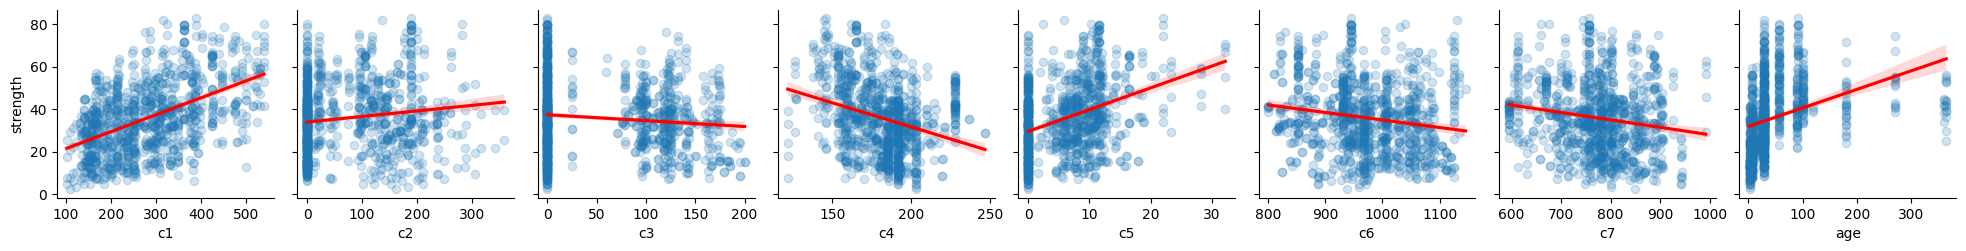

In [6]:
sns.pairplot(df, y_vars = col_names[-1], x_vars = col_names[:-1], kind = 'reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.2}})

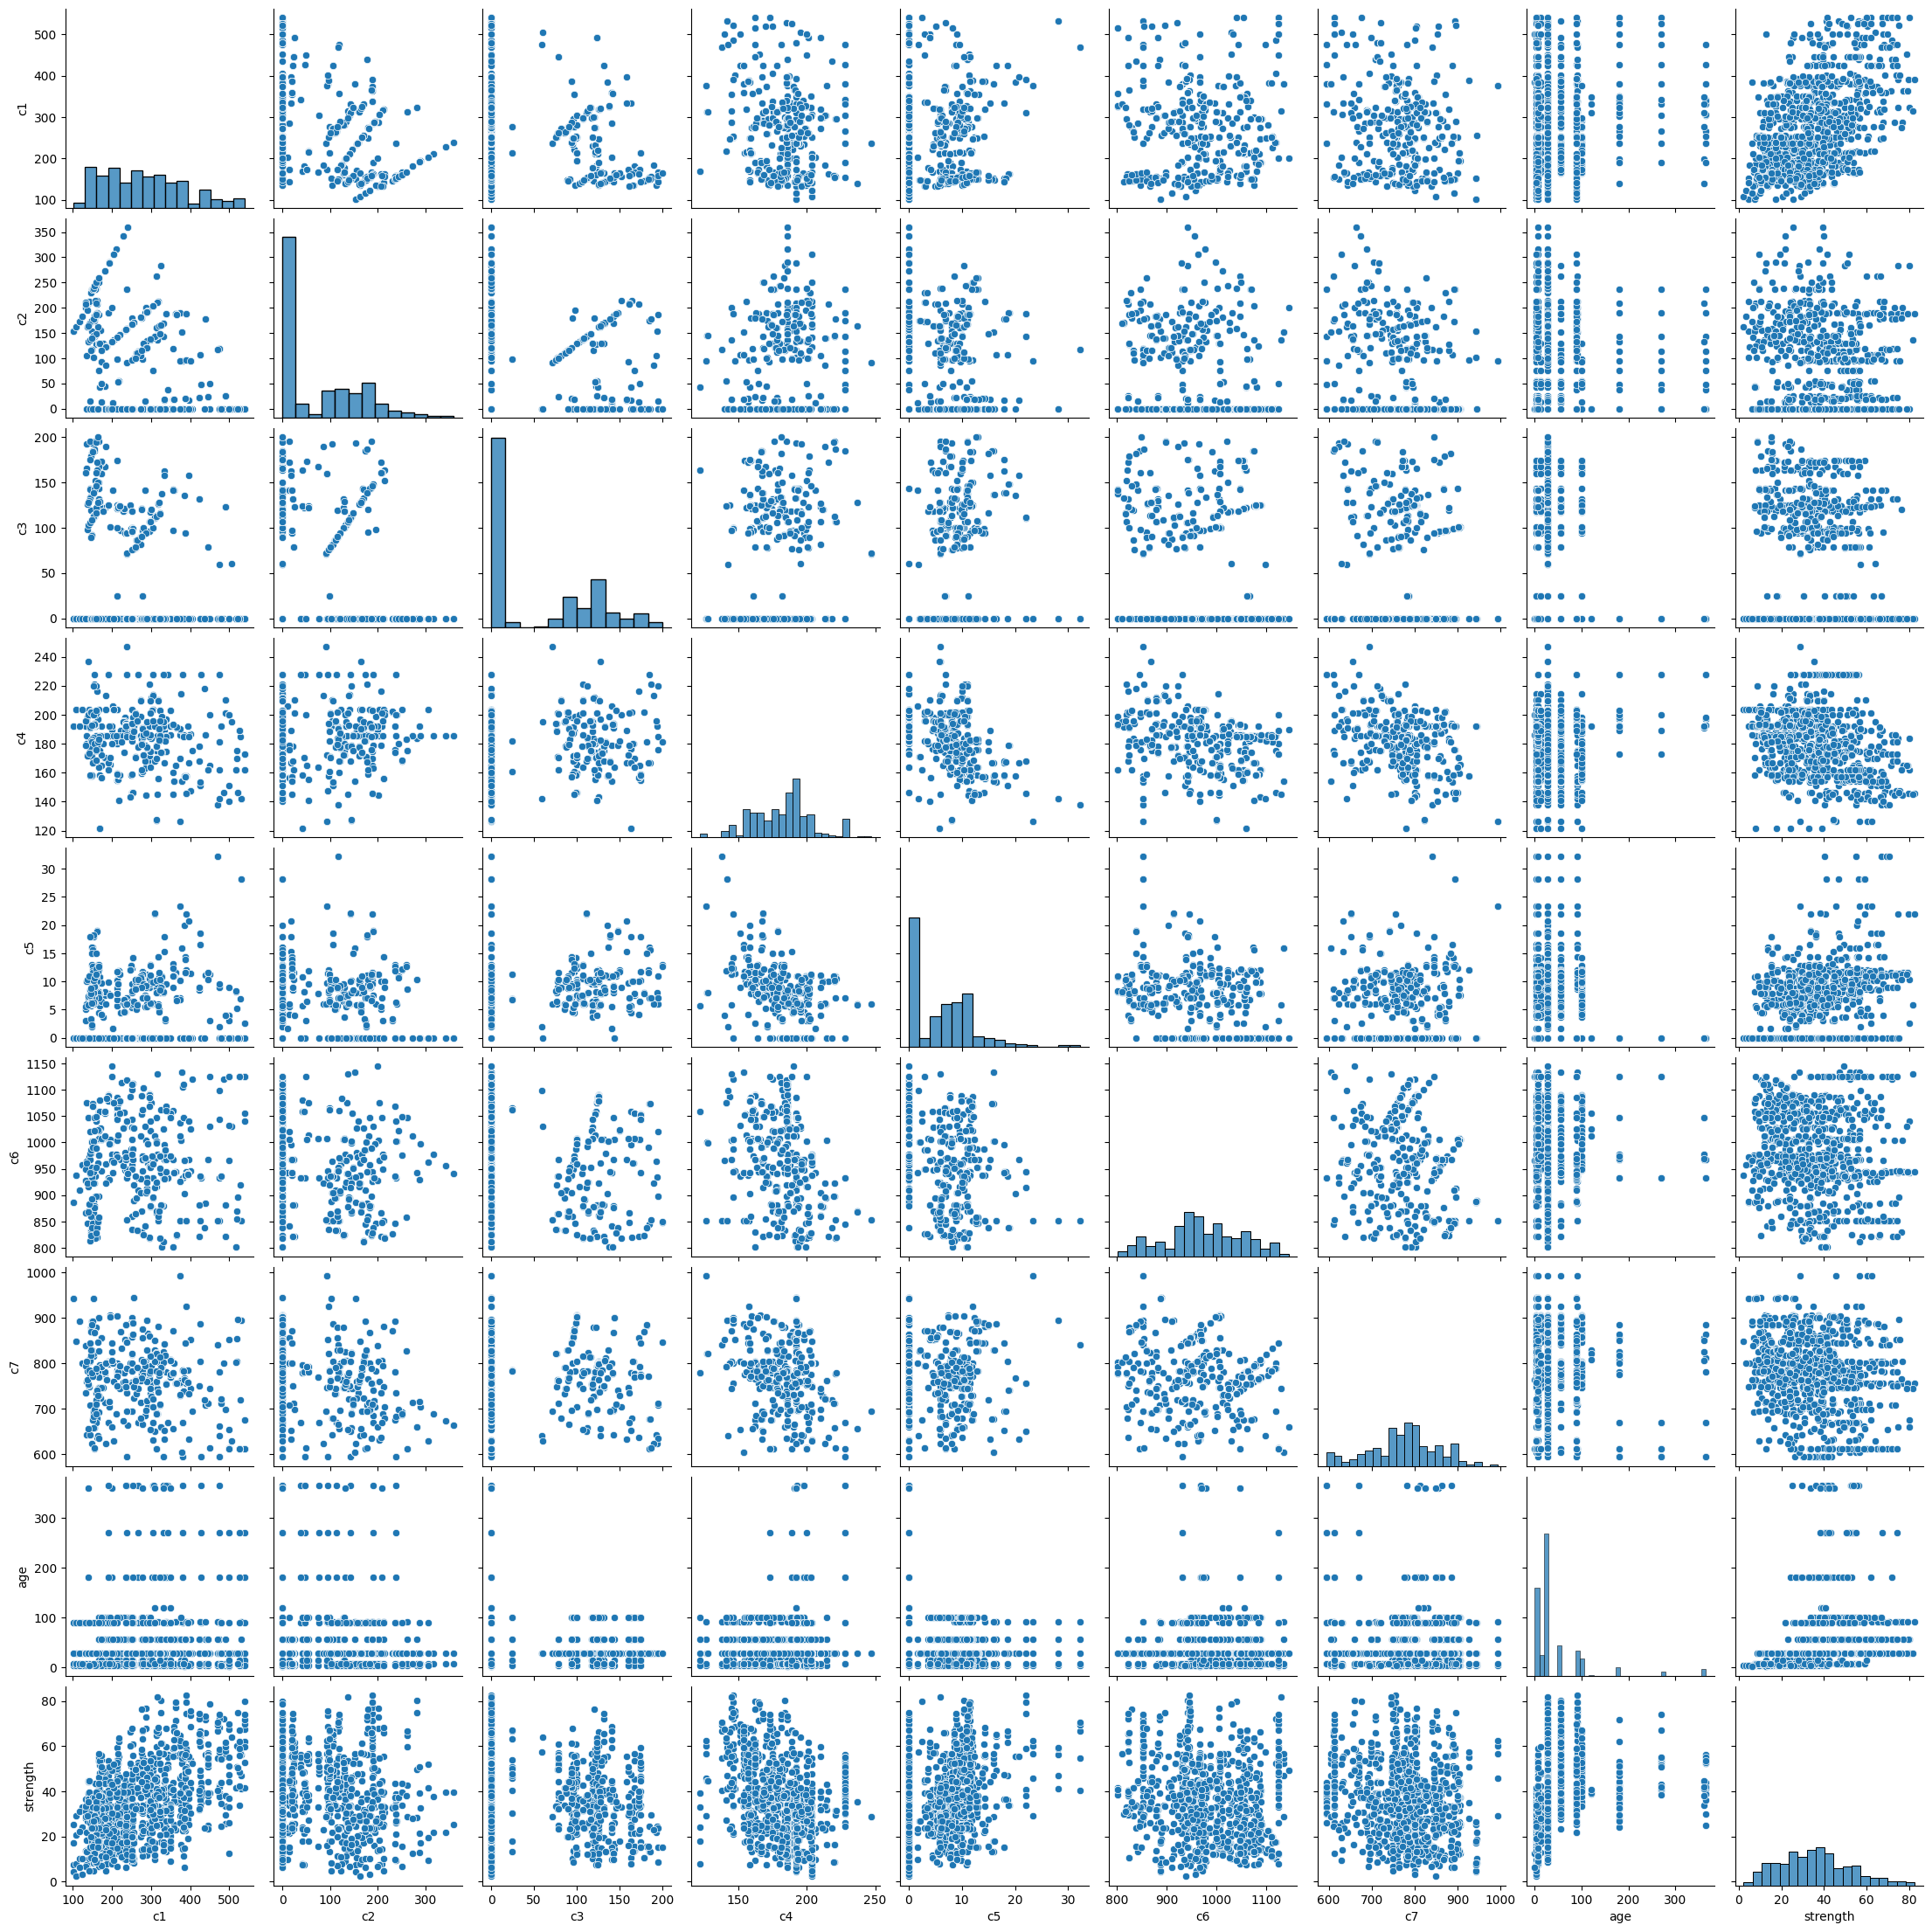

In [7]:
sns.pairplot(df)

## Data Preprocessing

### Extract X and Y

In [15]:
df_n = df.shape[0]

In [16]:
X = df.iloc[:, :-1].to_numpy()
Y = df.iloc[:, -1].to_numpy().reshape(df_n, 1)

### Log-Transform 'age'

In [17]:
X[:, 7] = np.log(X[:, 7])

Text(0, 0.5, 'strength')

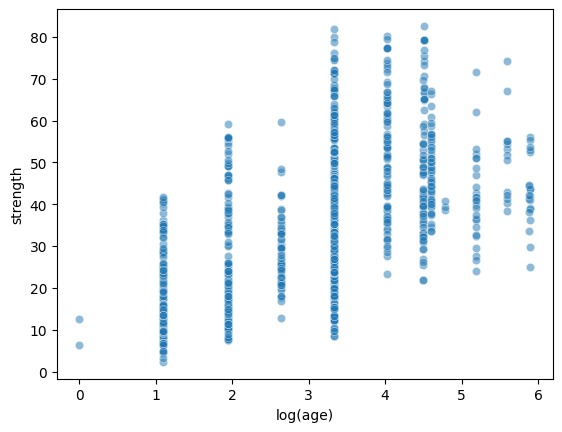

In [18]:
sns.scatterplot(x=X[:, 7], y=Y.ravel(), alpha=0.5)
plt.xlabel('log(age)')
plt.ylabel('strength')

In [19]:
# remove 'Superplasticity'
X = np.hstack((X[:, :4], X[:, 5:]))

### Split into train and test subsets

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=156)

### Scale Data

In [21]:
X_scaled = preprocessing.StandardScaler().fit_transform(X_train)
Y_scaled = preprocessing.StandardScaler().fit_transform(Y_train)

## Linear Regression

In [22]:
A = X_scaled.T @ X_scaled
b = X_scaled.T @ Y_scaled

In [23]:
A_n = A.shape[0]

In [24]:
def retrieve_coef(beta, x, y):
    ''' 
    Function to retrieve the unscaled betas and intercept.
    Beta is an (n x 1) vector containing the beta estimates from scaled data.
    X is the unscaled X array (with no intercept column).
    Y is the unscaled Y array.

    The output is an (n+1 x 1) containin the intercept and beta estimates.
    '''
    # add intercept
    beta = np.vstack((0, beta))
    
    # calculate coefficients
    ret_coef = np.std(y) / np.std(x, axis=0) * beta.ravel()[1:] 
    n = len(ret_coef)
    ret_coef = ret_coef.reshape((n, 1))

    # calculate intecept
    y_bar = np.mean(y)
    x_bars = np.mean(x, axis=0)

    betax = []

    for a, b in zip(ret_coef, x_bars):
        betax.append(a*b)

    sum_betax = np.sum(betax)
    
    beta0 = y_bar - sum_betax

    # combine intercept and coefficients
    coef = np.vstack((beta0, ret_coef))

    return coef

### LU

In [25]:
def LU(A, b):
    start = perf_counter()

    lu, piv = lu_factor(A)
    x = lu_solve((lu, piv), b)

    end = perf_counter()
    time = end - start

    result = {'x': x, 
              'time': time}
    
    return result

In [26]:
result_lu = LU(A, b)
beta_lu= result_lu['x']
coef_lu = retrieve_coef(beta_lu, X_train, Y_train)
coef_lu

array([[-56.00942368],
       [  0.13163052],
       [  0.11228574],
       [  0.09436017],
       [ -0.16021338],
       [  0.02095906],
       [  0.02921231],
       [  8.73695784]])

### Cholesky

In [27]:
def Cholesky(A, b):
    start = perf_counter()

    c, low = cho_factor(A, lower=True)
    x = cho_solve((c, low), b)

    end = perf_counter()
    time = end - start

    result = {'x': x, 
              'time': time}
    return result

In [28]:
result_cho = Cholesky(A, b)
beta_cho = result_cho['x']

coef_cho = retrieve_coef(beta_cho, X_train, Y_train)
coef_cho

array([[-56.00942368],
       [  0.13163052],
       [  0.11228574],
       [  0.09436017],
       [ -0.16021338],
       [  0.02095906],
       [  0.02921231],
       [  8.73695784]])

### QR

In [29]:
def QR(A, b):
    start = perf_counter()

    q, r = qr(A)
    z = q.T @ b
    x = solve_triangular(r, z)

    end = perf_counter()
    time = end - start

    result = {'x': x, 
              'time': time}
    return result

In [30]:
result_qr = QR(A, b)
beta_qr = result_qr['x']

coef_qr = retrieve_coef(beta_qr, X_train, Y_train)
coef_qr

array([[-56.00942368],
       [  0.13163052],
       [  0.11228574],
       [  0.09436017],
       [ -0.16021338],
       [  0.02095906],
       [  0.02921231],
       [  8.73695784]])

### Jacobi

In [31]:
def jacobi(A, b, epsilon=1e-3, x=None):
   start = perf_counter()

   n = A.shape[0]

   if not x:
      x = np.full((n, 1), 1/n)
    
   D = np.diag(A).reshape(n, 1)
   R = A - np.diagflat(D)

   while np.linalg.norm(A @ x - b) > epsilon:
      x = (b - np.dot(R, x)) / D

   end = perf_counter()
   time = end - start

   result = {'x': x, 
              'time': time}
   return result

In [32]:
# initial guess
beta0 = np.full((A_n, 1), 1/A_n)

# run Jacobi algorithm
result_jacobi = jacobi(A, b)
beta_jacobi = result_jacobi['x']
coef_jacobi = retrieve_coef(beta_jacobi, X_train, Y_train)
coef_jacobi

array([[-56.00024745],
       [  0.13162751],
       [  0.11228215],
       [  0.09435589],
       [ -0.16022491],
       [  0.02095612],
       [  0.02920862],
       [  8.73695042]])

### Gauss-Seidel

In [33]:
def gauss_seidel(A, b, k=250, epsilon=1e-6, x=None):
    start = perf_counter()

    n = A.shape[0]

    if not x:
        x = np.full((n, 1), 1/n)

    for _ in range(k):
        new_x = np.zeros(n)
        for j in range(n):
            ax1 = np.dot(A[j, :j], new_x[:j])
            ax = np.dot(A[j, j+1:], x[j+1:])
            new_x[j] = (b[j] - ax1 - ax) / A[j, j]
        
        if np.allclose(x, new_x, rtol = epsilon, atol = epsilon):
            return x.reshape(n, 1)
        
        x = new_x.reshape(n, 1)

    end = perf_counter()
    time = end - start    

    result = {'x': x, 
              'time': time}
    return result

In [34]:
beta0 = np.full((A_n, 1), 1/A_n)

result_gauss = gauss_seidel(A, b, k=250, epsilon=1e-3)
beta_gauss = result_gauss['x']

coef_gauss = retrieve_coef(beta_gauss, X_train, Y_train)
coef_gauss

array([[-56.00941686],
       [  0.13163052],
       [  0.11228573],
       [  0.09436017],
       [ -0.16021339],
       [  0.02095905],
       [  0.02921231],
       [  8.73695784]])

### Successive over-relaxation (SOR)

In [35]:
def SOR(A, b, w, k=250, epsilon=1e-6, x=None):
    start = perf_counter() 

    n = A.shape[0]

    if not x:
        x = np.full((n, 1), 1/n)

    for _ in range(k):
        new_x = np.zeros(n)
        for j in range(n):
            ax1 = np.dot(A[j, :j], new_x[:j])
            ax = np.dot(A[j, j+1:], x[j+1:])
            new_x[j] = (w * (b[j] - ax1 - ax) / A[j, j]) + (1-w)*x[j]

        if np.allclose(x, new_x, rtol = epsilon, atol = epsilon):
            return x.reshape(n, 1)
        
        x = new_x.reshape(n, 1)
    
    end = perf_counter()
    time = end - start

    result = {'x': x, 
              'time': time}
    return result

In [36]:
w = 0.5
result_SOR = SOR(A, b, w, 1000, 1e-3)
beta_SOR = result_SOR['x']

coef_sor = retrieve_coef(beta_SOR, X_train, Y_train)
coef_sor

array([[-56.00942359],
       [  0.13163052],
       [  0.11228574],
       [  0.09436017],
       [ -0.16021338],
       [  0.02095906],
       [  0.02921231],
       [  8.73695784]])

### SVD

In [37]:
def SVD(A, b):
    n = A.shape[0]

    start = perf_counter()

    U, s, Vh = svd(A)
    s = np.diagflat(s)
    x = Vh.T @ np.reciprocal(s, where=s!=0, out=np.zeros_like(s)) @ U.T @ b

    end = perf_counter()
    time = end - start

    result = {'x': x, 
              'time': time}
    
    
    return result

In [38]:
result_svd = SVD(A, b)
beta_svd = result_svd['x']

coef_svd = retrieve_coef(beta_svd, X_train, Y_train)
coef_svd

array([[-56.00942368],
       [  0.13163052],
       [  0.11228574],
       [  0.09436017],
       [ -0.16021338],
       [  0.02095906],
       [  0.02921231],
       [  8.73695784]])

### Gradient Boosting Regression

In [39]:
from sklearn import ensemble
from sklearn.metrics import r2_score, mean_squared_error

In [40]:
def GBR(A, b):
    gbr_start = perf_counter()

    params = {
        "n_estimators": 500,
        "max_depth": 4,
        "min_samples_split": 5,
        "learning_rate": 0.01,
        "loss": "squared_error",
    }

    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X_train, Y_train.reshape(Y_train.shape[0],))

    gbr_end = perf_counter()

    pred = reg.predict(X_test)

    result = {
        'preds': pred,
        'resids': Y_test - pred,
        'R2': r2_score(Y_test, pred),
        'MSE': mean_squared_error(Y_test, pred),
        'time': gbr_end - gbr_start
    }
    
    return result

In [41]:
GBR(A, b)

{'preds': array([30.69822543, 11.74489181, 24.71551878, 13.32251894, 31.48232427,
        17.60467072, 18.82373068, 40.6850924 , 25.68301113, 23.61300321,
        36.34235346, 30.69822543, 25.56304287, 31.99035483, 38.90839524,
        10.11161311, 19.97426212, 10.85875962, 31.48773928, 61.942271  ,
        41.62673981, 49.7412072 , 43.52597886, 19.69107423, 39.7707609 ,
        13.6739823 , 37.33067469, 28.01274034, 49.3434852 , 24.48317585,
        30.47935493, 37.65711161, 32.64566924, 23.31913989, 49.11631437,
        48.26685476, 59.70799006, 34.68376483, 32.43837813, 24.0361346 ,
        33.14365559, 33.61279557, 62.96321735, 27.46509438, 14.93918449,
        48.66830129, 24.41379107, 53.00800982, 34.49584918, 39.45746332,
        23.66243508, 31.97313697, 30.58074649, 47.19870422, 49.41955757,
        42.51229311, 64.92771681, 29.35371039, 44.20775535, 47.24722796,
        17.8247343 , 19.4043355 , 30.18065162, 38.47337757, 40.3439321 ,
        16.40206091, 42.17959769, 50.90300

## Model Accuracy

In [46]:
def predict_score(coef, x_test, y_test, x_train, intercept=False):
    n, p = x_test.shape
    n1, p1 = x_train.shape
    
    if not intercept:
        x_train = np.hstack((np.ones((n1, 1)), x_train))
        x_test = np.hstack((np.ones((n, 1)), x_test))
        p += 1
    
    y_pred = x_test @ coef

    resids = y_test - y_pred

    y_bar = np.mean(y_test)

    mse = np.sum([(y - y_hat)**2 for y, y_hat in zip(y_test, y_pred)]) / (n-p)

    msto = np.sum([(y - y_bar)**2 for y in y_test]) / (n-1)

    msr = (msto*(n-1) - mse*(n-p)) / (p-1)

    se = np.sqrt(mse * np.diag(np.linalg.inv(x_train.T @ x_train))).reshape(p, 1)

    r2 = (msr*(p-1)) / (msto*(n-1))

    r2_adj = 1 - (mse/msto)

    test_stats = coef / se

    pvals = np.asarray([scipy.stats.t.sf(abs(t), df=n-p-1)*2 for t in test_stats]).reshape(p, 1)

    Fstat = msr/mse

    Fpval = 1 - scipy.stats.f.cdf(Fstat, p-1, n-p)

    shapiro = scipy.stats.shapiro(x_test)[1]

    durbin = durbin_watson(resids)[0]
    
    results = {
        'preds': y_pred,
        'resids': resids,
        'SE': se,
        'R2': r2,
        'R2_Adj': r2_adj,
        'MSE': mse,
        'test-statistics': test_stats,
        'P-values': pvals,
        'F-statistic': Fstat,
        'F-statistic P-value': Fpval,
        'Shapiro-Wilks P-value': shapiro,
        'Durbin-Watson': durbin
    }


    return results

## Model Selection

In [43]:
import statsmodels.api as sm

In [44]:
model = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     519.0
Date:                Thu, 16 Mar 2023   Prob (F-statistic):          2.42e-285
Time:                        13:05:52   Log-Likelihood:                -2596.4
No. Observations:                 772   AIC:                             5209.
Df Residuals:                     764   BIC:                             5246.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -56.0094     19.600     -2.858      0.004     -94.486     -17.533
x1             0.1316      0.007     19.867      0.000       0.119       0.145
x2             0.1123      0.008     14.165      0.000       0.097       0.128
x3             0.0944      0.010      9.753      0.000       0.075       0.113
x4            -0.1602      0.027     -5.989      0.000      -0.213      -0.108
x5             0.0210      0.007      3.066      0.002       0.008       0.034
x6             0.0292      0.008      3.550      0.000       0.013       0.045
x7             8.7370      0.214     40.885      0.000       8.317       9.156
==============================================================================
Omnibus:                        3.762   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                3.640
Skew:                           0.165   Prob(JB):                        0.162
Kurtosis:                       3.062   Cond. No.                     1.00e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
# remove c5
X_rm = np.hstack((X[:, :4], X[:, 5:]))
X_train_rm, X_test_rm, Y_train, Y_test = train_test_split(X_rm, Y, random_state=156)
model_rm = sm.OLS(Y_train, sm.add_constant(X_train_rm)).fit()
model_rm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     597.4
Date:                Thu, 16 Mar 2023   Prob (F-statistic):          1.01e-284
Time:                        13:05:55   Log-Likelihood:                -2601.1
No. Observations:                 772   AIC:                             5216.
Df Residuals:                     765   BIC:                             5249.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2988      6.889      0.043      0.965     -13.225      13.823
x1             0.1149      0.004     30.515      0.000       0.107       0.122
x2             0.0918      0.004     21.486      0.000       0.083       0.100
x3             0.0709      0.006     11.925      0.000       0.059       0.083
x4            -0.2259      0.016    -14.010      0.000      -0.258      -0.194
x5             0.0082      0.005      1.789      0.074      -0.001       0.017
x6             8.6842      0.214     40.549      0.000       8.264       9.105
==============================================================================
Omnibus:                        1.446   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.485   Jarque-Bera (JB):                1.355
Skew:                           0.101   Prob(JB):                        0.508
Kurtosis:                       3.039   Cond. No.                     2.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
predict_score(model_rm.params.reshape(7, 1), X_test_rm, Y_test, X_train_rm)

{'preds': array([[34.56152484],
        [12.53269425],
        [22.69190661],
        [ 9.01752727],
        [36.88683829],
        [20.19300914],
        [29.23583098],
        [40.40095548],
        [22.34155563],
        [29.10572381],
        [37.35614329],
        [34.56152484],
        [29.59952962],
        [33.00604989],
        [34.15462633],
        [ 1.33079653],
        [27.02719032],
        [ 8.16584681],
        [36.123058  ],
        [70.65323813],
        [41.27120548],
        [41.87192393],
        [59.44278685],
        [19.35441118],
        [40.47591568],
        [ 8.84957027],
        [38.81253912],
        [26.10837558],
        [41.96698481],
        [23.92610327],
        [36.12790493],
        [37.40136811],
        [33.03955293],
        [25.31730791],
        [47.94385183],
        [48.8761253 ],
        [50.47886635],
        [36.59669556],
        [31.52794407],
        [17.5578561 ],
        [31.4918249 ],
        [34.41700966],
        [70.40331447],
  

## Model Selection w/ Interaction Terms

In [49]:
from itertools import combinations

In [50]:
inter_df = pd.DataFrame(df, columns = list(df.columns)[:-1])
inter_df['age'] = np.log(inter_df['age'])
inter_df

,c1,c2,c3,c4,c5,c6,c7,age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,3.332205
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,3.332205
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5.598422
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5.899897
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5.886104
...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,3.332205
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,3.332205
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,3.332205
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,3.332205


In [51]:
inter_factors=list(df.columns)[:-1]
inter_combos = []

In [52]:
for n in range(2,len(inter_factors) + 1):
    inter_combos += list(combinations(inter_factors, n))

In [53]:
for combo in inter_combos:
    col_name = str(combo)[1:-1].replace("'", "").replace(", ", "|")
    inter_df[col_name] = 1
    for col in combo:
        inter_df[col_name] = inter_df[col_name] * inter_df[col]

C:\Users\Connor\AppData\Local\Temp\ipykernel_29708\3237363602.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\Connor\AppData\Local\Temp\ipykernel_29708\3237363602.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\Connor\AppData\Local\Temp\ipykernel_29708\3237363602.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fr

In [54]:
inter_df

,c1,c2,c3,c4,c5,c6,c7,age,c1|c2,c1|c3,...,c3|c4|c5|c6|c7|age,c1|c2|c3|c4|c5|c6|c7,c1|c2|c3|c4|c5|c6|age,c1|c2|c3|c4|c5|c7|age,c1|c2|c3|c4|c6|c7|age,c1|c2|c3|c5|c6|c7|age,c1|c2|c4|c5|c6|c7|age,c1|c3|c4|c5|c6|c7|age,c2|c3|c4|c5|c6|c7|age,c1|c2|c3|c4|c5|c6|c7|age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,3.332205,0.00,0.00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,3.332205,0.00,0.00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5.598422,47381.25,0.00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5.899897,47381.25,0.00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5.886104,26294.64,0.00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,3.332205,32062.40,24958.92,...,3.215257e+11,3.093714e+15,1.341779e+13,1.184793e+13,1.158302e+15,5.739915e+13,1.141626e+14,8.886971e+13,3.729699e+13,1.030889e+16
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,3.332205,0.00,37246.32,...,5.223761e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.683096e+14,0.000000e+00,0.000000e+00
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,3.332205,20700.90,16127.10,...,2.960924e+11,1.839436e+15,7.858177e+12,6.868420e+12,1.004816e+15,3.180788e+13,5.643995e+13,4.396971e+13,4.127527e+13,6.129378e+15
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,3.332205,29703.97,0.00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.533313e+14,0.000000e+00,0.000000e+00,0.000000e+00


In [55]:
X_inter_train, X_inter_test, Y_train, Y_test = train_test_split(inter_df, Y, random_state=156)

## Lasso

In [153]:
X_inter_scaled = preprocessing.StandardScaler().fit_transform(X_inter_train)
Y_inter_scaled = preprocessing.StandardScaler().fit_transform(Y_train)
X_inter_test_scaled = preprocessing.StandardScaler().fit_transform(X_inter_test)

In [71]:
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel

In [183]:
lasso = linear_model.Lasso(alpha=0.01)
selector = SelectFromModel(estimator=lasso).fit(X_inter_scaled, Y_inter_scaled)
selected_features = inter_df.columns[selector.get_support()]

scaled_transformed_coef = selector.estimator_.coef_
scaled_transformed_coef = scaled_transformed_coef[scaled_transformed_coef!=0]
scaled_transformed_coef = np.array(scaled_transformed_coef).reshape(len(scaled_transformed_coef), 1)


X_inter_scaled_transformed = selector.transform(X_inter_scaled)
X_inter_test_scaled_transformed = selector.transform(X_inter_test_scaled)

transformed_coef = retrieve_coef(scaled_transformed_coef, X_inter_scaled_transformed, Y_train)

In [184]:
inter_df.columns[selector.get_support()]

Index(['c1|c6', 'c4|c6', 'c4|c7', 'c6|age', 'c1|c6|c7', 'c3|c4|c5', 'c4|c6|c7',
       'c6|c7|age', 'c1|c5|c7|age', 'c1|c6|c7|age', 'c2|c3|c6|c7',
       'c2|c4|c5|c6', 'c2|c4|c7|age', 'c2|c6|c7|age', 'c3|c6|c7|age',
       'c1|c2|c3|c4|c5', 'c1|c2|c4|c5|c6', 'c1|c2|c4|c7|age',
       'c1|c3|c6|c7|age', 'c2|c3|c6|c7|age', 'c2|c4|c5|c6|age',
       'c1|c2|c3|c6|c7|age', 'c2|c4|c5|c6|c7|age'],
      dtype='object')

In [185]:
predict_score(transformed_coef, X_inter_scaled_transformed, Y_train, X_inter_scaled_transformed)['R2']

c:\Users\Connor\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.


0.8668446773415616

In [186]:
predict_score(transformed_coef, X_inter_test_scaled_transformed, Y_test, X_inter_scaled_transformed)['R2']

0.8253143801309851

## Step-wise model selection

In [52]:
def model_selection(X, Y):
    complete = False
    exclude = []

    while not complete:
        reg = sm.OLS(Y, sm.add_constant(X.loc[:, ~X.columns.isin(exclude)])).fit()
        result_df = pd.read_html(reg.summary().tables[1].as_html(), header=0, index_col=0)[0].iloc[::-1]
        row_count = result_df.shape[0]
        i=0
        for index, row in result_df.iterrows():
            i+=1
            if row['P>|t|'] > 0.05:
                exclude.append(index)
                break
        if i == row_count:
            complete = True     

    return reg, exclude

In [53]:
model, excluded_terms = model_selection(X_inter_train, Y_train)

In [54]:
final_coef = np.array(model.params).reshape(len(model.params), 1)
final_coef

array([[ 0.00555397],
       [-1.33329983],
       [-0.09758624],
       [ 3.08586362],
       [-0.01296606],
       [-1.00621524],
       [ 0.48804193],
       [ 0.03902171],
       [ 0.04386295],
       [-0.32095297],
       [ 0.00330465],
       [-0.07085507],
       [-2.05111892],
       [ 0.90115711],
       [ 0.0129826 ],
       [ 0.16646853],
       [ 0.00381712],
       [-0.00212188],
       [-0.59914989],
       [-0.60233899],
       [ 0.00211777],
       [-0.00616744],
       [-0.05060767],
       [ 0.1038523 ],
       [ 0.00072043],
       [ 0.01480934],
       [-0.0244471 ],
       [ 0.01174317],
       [ 0.00199487],
       [ 0.00001372],
       [-0.00001845],
       [-0.00022938],
       [ 0.00045515],
       [-0.00002303],
       [-0.00003428],
       [-0.00170498],
       [ 0.00149616],
       [-0.00000905],
       [ 0.00000949],
       [ 0.00025731],
       [ 0.04461481],
       [-0.00000213],
       [ 0.00013104],
       [ 0.01024308],
       [-0.11672006],
       [ 0

In [ ]:
model.summary()

### New model w/ testing data

In [56]:
X_inter_train_rm = X_inter_train.loc[:, ~X_inter_train.columns.isin(excluded_terms)]
X_inter_train_rm.insert(0, 'inter', 1)

In [57]:
X_inter_test_rm = X_inter_test.loc[:, ~X_inter_test.columns.isin(excluded_terms)]
X_inter_test_rm.insert(0, 'inter', 1)

In [103]:
predict_score(final_coef, X_inter_train_rm.to_numpy(), Y_train, X_inter_train_rm.to_numpy(), intercept=True)

{'preds': array([[22.27163132],
        [54.64337124],
        [49.47472178],
        [59.10771722],
        [29.90865603],
        [25.80190137],
        [36.29491151],
        [42.09397145],
        [30.18600824],
        [48.0899897 ],
        [17.45934005],
        [21.6159722 ],
        [12.90228101],
        [37.42604707],
        [29.46818448],
        [48.44495133],
        [52.83805744],
        [52.02929387],
        [15.60644705],
        [81.77457336],
        [41.78285344],
        [42.79634007],
        [40.67364633],
        [16.08091931],
        [31.43575158],
        [79.09015274],
        [30.79671916],
        [57.90891698],
        [11.89469474],
        [47.53287453],
        [26.8085446 ],
        [18.94662005],
        [49.7627194 ],
        [34.31778382],
        [15.02065288],
        [33.11292405],
        [48.76084479],
        [25.41559639],
        [37.47998216],
        [46.24104459],
        [43.05894305],
        [14.80039445],
        [ 7.64493383],
  

In [61]:
predict_score(final_coef, X_inter_test_rm.to_numpy(), Y_test, X_inter_train_rm.to_numpy(), intercept=True)

180.445193897223

## Computation Speed Comparison

In [62]:
def speedTest(func, A, b, n, **kwargs):
    times = [func(A, b, **kwargs)['time'] for _ in range(n)]
    mean = np.mean(times)
    return mean
    

In [63]:
# LU
mean_lu = speedTest(LU, A, b, n=1_000_000)
mean_lu

1.0704823800406302e-05

In [78]:
# Cholesky
mean_cho = speedTest(Cholesky, A, b, n=1_000_000)
mean_cho

1.4993259394803318e-05

In [79]:
# QR
mean_qr= speedTest(QR, A, b, n=1_000_000)
mean_qr

4.720440540097479e-05

In [80]:
# Jacobi
mean_jacobi = speedTest(jacobi, A, b, n=1000)
mean_jacobi

0.002576736399627407

In [81]:
# Gauss-Seidel
mean_gauss = speedTest(gauss_seidel, A, b, n=1000)
mean_gauss

0.01899438559990085

In [187]:
# SOR, w = 0.25
mean_sor_025  = speedTest(SOR, A, b, n=1000, w=0.25)
mean_sor_025

0.027468859099724796

In [71]:
# SOR, w = 0.5
mean_sor_05 = speedTest(SOR, A, b, n=1000, w=0.5)
mean_sor_05

0.02736342479995801

In [73]:
# SOR, w = 0.75
mean_sor_075 = speedTest(SOR, A, b, n=1000, w=0.75)
mean_sor_075

0.027139279699993496

In [75]:
# SOR, w = 1
mean_sor_1 = speedTest(SOR, A, b, n=1000, w=1)
mean_sor_1

0.029098607299747527

In [82]:
# SOR, w = 1.25
mean_sor_125 = speedTest(SOR, A, b, n=1000, w=1.25)
mean_sor_125

0.024703692700059038

In [76]:
# SOR, w = 1.5
mean_sor_15 = speedTest(SOR, A, b, n=1000, w=1.5)
mean_sor_15

0.027261433099971328

In [77]:
# SOR, w = 1.75
mean_sor_175 = speedTest(SOR, A, b, n=1000, w=1.75)
mean_sor_175

0.027399155899998733

In [83]:
# SVD
mean_svd = speedTest(SVD, A, b, n=1_000_000)
mean_svd

5.486129060483654e-05

In [84]:
# GBR
mean_gbd = speedTest(GBR, A, b, n=100)
mean_gbd

0.44278904000006153

## Computation Speed and Accuracy Table

In [87]:
method_coef = [coef_lu, coef_cho, coef_qr, coef_jacobi, coef_gauss, coef_sor, coef_svd]

mses = [predict_score(coef, X_test, Y_test, X_train)['MSE'] for coef in method_coef] + [GBR(A, b)['MSE']]

r2s = [predict_score(coef, X_test, Y_test, X_train)['R2'] for coef in method_coef] + [GBR(A, b)['R2']]

comp_times = [mean_lu, mean_cho, mean_qr, mean_jacobi ,mean_gauss, mean_sor_125, mean_svd, mean_gbd]

column_names = ['LU', 'Cholesky', 'QR', 'Jacobi','Gauss-Seidel', 'SOR (w=1.25)', 'SVD', 'Gradient Boosting Regression']

In [88]:
df_comp = pd.DataFrame(
    data = [column_names, mses, r2s, comp_times]
).T
df_comp.rename(columns = {0: 'Method', 1: 'MSE', 2:'R^2', 3:'Run time'})

,Method,MSE,R^2,Run time
0,LU,58.773046,0.790492,0.000011
1,Cholesky,58.773046,0.790492,0.000015
2,QR,58.773046,0.790492,0.000047
3,Jacobi,58.773165,0.790492,0.002577
4,Gauss-Seidel,58.773046,0.790492,0.018994
5,SOR (w=1.25),58.773046,0.790492,0.024704
6,SVD,58.773046,0.790492,0.000055
7,Gradient Boosting Regression,32.402717,0.880458,0.442789


## Simulation Study

In [63]:
# set true parameters
np.random.seed(109)
p_sim = 9
beta_true = np.random.randint(low=0, high=10, size=(p_sim, 1))
sigma_true = np.random.randint(low=1, high = 5)
beta_true, sigma_true**2

(array([[6],
        [5],
        [5],
        [0],
        [1],
        [4],
        [9],
        [3],
        [0]]),
 4)

In [64]:
# generate X from true model
n_sim = 300
X_sim = np.random.default_rng().uniform(low=0, high=10, size=(n_sim, p_sim-1))
X_sim = np.hstack((np.ones((n_sim, 1)), X_sim))

In [65]:
def simulation(i, X, beta, sigma):
    n, p = X.shape

    np.random.seed(53 + i)

    y = X @ beta + np.random.normal(loc = 0, scale = sigma, size = (n, 1))

    A = X.T @ X
    b = X.T @ y 

    beta_sim = LU(A, b)['x']
    model_summary = predict_score(beta_sim, X, y, X, intercept=True)
    sigma_sim = model_summary['MSE'].reshape(1, 1)

    beta_sim = beta_sim.reshape(1, p)

    result = np.hstack((beta_sim, sigma_sim))
    return result

In [68]:
sim_results.shape

(100, 10)

In [66]:
true_params = np.hstack((beta_true.reshape(1, p_sim), np.array(sigma_true**2).reshape(1,1)))[0]
sim_results = [simulation(i, X_sim, beta_true, sigma_true) for i in range(100)]
sim_results = np.vstack(sim_results)
sim_results_means = np.mean(sim_results, axis=0)
sim_results_stds = np.std(sim_results, axis=0)

pd.DataFrame(
    data = [true_params, sim_results_means, sim_results_stds],
    columns = ['Beta 0', 'Beta 1', 'Beta 2', 'Beta 3',
               'Beta 4', 'Beta 5', 'Beta 6', 'Beta 7',
               'Beta 8', 'Sigma^2'],
    index = ['True Value', 'Mean', 'SD']
)

,Beta 0,Beta 1,Beta 2,Beta 3,Beta 4,Beta 5,Beta 6,Beta 7,Beta 8,Sigma^2
True Value,6.000000,5.000000,5.000000,0.000000,1.000000,4.000000,9.000000,3.000000,0.000000,4.000000
Mean,6.049902,4.998698,5.002115,-0.006492,0.993214,4.000734,9.007746,2.997993,-0.000756,4.003003
SD,0.553009,0.045645,0.042365,0.034704,0.041740,0.037304,0.034636,0.039400,0.042073,0.339179
